In [ ]:
#Libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, precision_recall_curve
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import tensorflow as tf
from imblearn.over_sampling import SMOTE

In [ ]:
# Load Dataset
data_path = "/content/Synthetic_Financial_datasets_log.csv"
data = pd.read_csv(data_path)
data.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0.0,0.0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0.0,0.0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1.0,0.0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1.0,0.0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0.0,0.0


In [ ]:
data.shape

(2129321, 11)

In [ ]:
data.columns

Index(['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud',
       'isFlaggedFraud'],
      dtype='object')

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2129321 entries, 0 to 2129320
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         float64
 10  isFlaggedFraud  float64
dtypes: float64(7), int64(1), object(3)
memory usage: 178.7+ MB


In [ ]:
# Drop irrelevant columns and any NaN values
data = data.drop(['oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest', 'nameOrig', 'nameDest'], axis=1)
data = data.dropna()

# Convert categorical 'type' column to numerical
label_encoder = LabelEncoder()
data['type'] = label_encoder.fit_transform(data['type'])

# Separate features and labels
features = data.drop(['isFraud'], axis=1)
labels = data['isFraud'].copy()

# Normalize features
scaler = MinMaxScaler()
features_scaled = scaler.fit_transform(features)

# Reshape features to 3D for LSTM
features_reshaped = features_scaled.reshape(features_scaled.shape[0], 1, features_scaled.shape[1])

In [ ]:
# Use k-fold cross-validation
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Store results for evaluation
results = []

for train_index, test_index in kf.split(features_reshaped, labels):
    X_train, X_test = features_reshaped[train_index], features_reshaped[test_index]
    y_train, y_test = labels[train_index], labels[test_index]

    # Apply SMOTE to handle class imbalance
    smote = SMOTE(random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train.reshape(X_train.shape[0], -1), y_train)

    # Reshape back to 3D for LSTM
    X_train_resampled = X_train_resampled.reshape(X_train_resampled.shape[0], 1, -1)

    # Define a LSTM model
    def LstmAutoEncoder(input_shape):
        model = Sequential([
            Input(shape=input_shape),
            LSTM(32, activation='relu', return_sequences=True),
            Dropout(0.3),
            LSTM(16, activation='relu', return_sequences=False),
            Dropout(0.3),
            Dense(16, activation='relu'),
            Dense(1, activation='sigmoid')
        ])
        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
        return model

    # Initialize model
    input_shape = (X_train_resampled.shape[1], X_train_resampled.shape[2])
    autoencoder = LstmAutoEncoder(input_shape)

    # Model checkpoint and early stopping
    checkpoint = ModelCheckpoint('fraud_detection_model.keras', save_best_only=True, monitor='val_loss', mode='min')
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

    # Train the model
    autoencoder.fit(
        X_train_resampled, y_train_resampled,
        epochs=10,
        batch_size=256,
        validation_data=(X_test, y_test),
        callbacks=[checkpoint, early_stopping]
    )

    # Load the best model
    model = tf.keras.models.load_model('fraud_detection_model.keras')

    # Evaluate the model
    predictions = model.predict(X_test)
    predicted_labels = (predictions > 0.5).astype(int)

    # Performance metrics
    accuracy = accuracy_score(y_test, predicted_labels)
    precision = precision_score(y_test, predicted_labels)
    recall = recall_score(y_test, predicted_labels)
    f1 = f1_score(y_test, predicted_labels)

    results.append((accuracy, precision, recall, f1))

# Average the results
mean_results = np.mean(results, axis=0)
print(f"Mean Accuracy: {mean_results[0]}, Mean Precision: {mean_results[1]}, Mean Recall: {mean_results[2]}, Mean F1 Score: {mean_results[3]}")

Epoch 1/10
13296/13296 ━━━━━━━━━━━━━━━━━━━━ 91s 6ms/step - accuracy: 0.8045 - loss: 0.3885 - val_accuracy: 0.9049 - val_loss: 0.2998
Epoch 2/10
13296/13296 ━━━━━━━━━━━━━━━━━━━━ 84s 6ms/step - accuracy: 0.8614 - loss: 0.2988 - val_accuracy: 0.9047 - val_loss: 0.2809
Epoch 3/10
13296/13296 ━━━━━━━━━━━━━━━━━━━━ 142s 6ms/step - accuracy: 0.8682 - loss: 0.2897 - val_accuracy: 0.9046 - val_loss: 0.2770
Epoch 4/10
13296/13296 ━━━━━━━━━━━━━━━━━━━━ 140s 6ms/step - accuracy: 0.8693 - loss: 0.2865 - val_accuracy: 0.9037 - val_loss: 0.2645
Epoch 5/10
13296/13296 ━━━━━━━━━━━━━━━━━━━━ 141s 6ms/step - accuracy: 0.8696 - loss: 0.2846 - val_accuracy: 0.9022 - val_loss: 0.2641
Epoch 6/10
13296/13296 ━━━━━━━━━━━━━━━━━━━━ 81s 6ms/step - accuracy: 0.8703 - loss: 0.2824 - val_accuracy: 0.8997 - val_loss: 0.2655
Epoch 7/10
13296/13296 ━━━━━━━━━━━━━━━━━━━━ 81s 6ms/step - accuracy: 0.8711 - loss: 0.2804 - val_accuracy: 0.8899 - val_loss: 0.2712
Epoch 8/10
13296/13296 ━━━━━━━━━━━━━━━━━━━━ 82s 6ms/step - accurac

Confusion Matrix:
 [[385647  39801]
 [    72    344]]


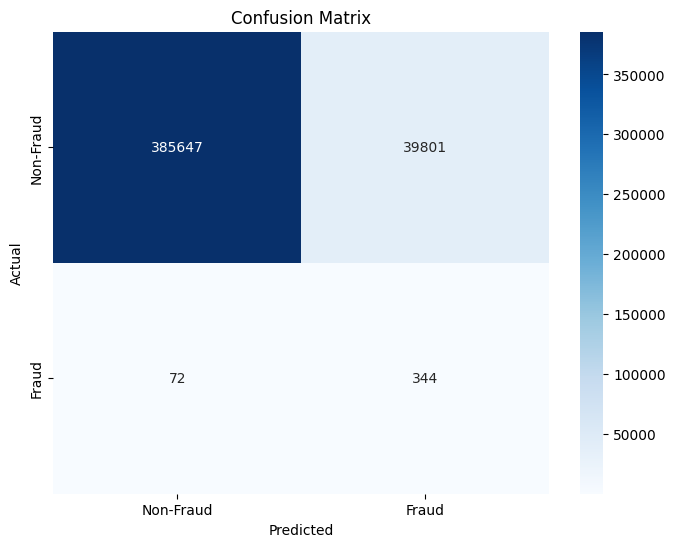

In [ ]:
# Confusion Matrix
final_predictions = (predictions > 0.5).astype(int)  # Use final predictions from the last fold for the confusion matrix
conf_matrix = confusion_matrix(y_test, final_predictions)
print("Confusion Matrix:\n", conf_matrix)

# Visualize Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Fraud', 'Fraud'], yticklabels=['Non-Fraud', 'Fraud'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

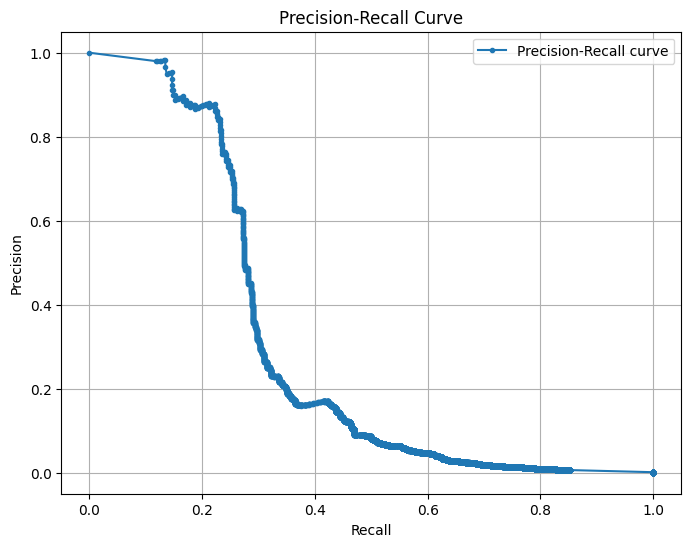

In [ ]:
# Precision-Recall Curve
precision_curve, recall_curve, _ = precision_recall_curve(y_test, predictions)
plt.figure(figsize=(8, 6))
plt.plot(recall_curve, precision_curve, marker='.', label='Precision-Recall curve')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.grid()
plt.show()

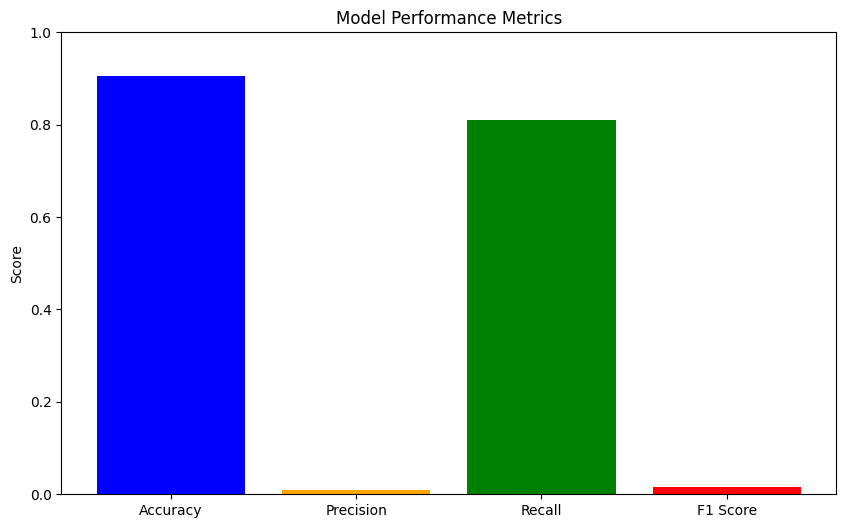

In [ ]:
# Visualize Performance Metrics
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
mean_values = mean_results

plt.figure(figsize=(10, 6))
plt.bar(metrics, mean_values, color=['blue', 'orange', 'green', 'red'])
plt.ylim(0, 1)
plt.title('Model Performance Metrics')
plt.ylabel('Score')
plt.show()